# **Project: Anomaly Detection for AITEX Dataset**
#### Track: VAE
## `Notebook 5`: Data Preparation & Exploration
**Author**: Oliver Grau 

**Date**: 27.03.2025  
**Version**: 1.0


## 📚 Table of Contents

- [1. Dataset Overview](#1-dataset-overview)
- [2. Image Cropping: Remove Left Margin](#image-cropping-remove-left-margin)
- [3. Image Tiling: Splitting into Patches](#3-image-tiling-splitting-into-patches)
- [4. Dataset Handling and Preprocessing Steps](#4-dataset-handling-and-preprocessing-steps)
- [5. Visual Exploration](#5-visual-exploration)
- [6. Conclusion & Outlook](#6-conclusion--outlook)

---

Before training an autoencoder for anomaly detection, it's crucial to properly prepare and understand the data. In this section, we describe the structure of the AITEX dataset, explain key preprocessing steps, and outline how we transform raw images into a suitable format for model training.

## 1. Dataset Structure Overview
The AITEX Fabric Defect Database consists of three main folders:

- `data/NODefect_images/`: Clean fabric images without defects (used for training)
- `data/Defect_images/`: Images that contain visible surface defects (used for testing/evaluation)
- `data/Mask_images/`: Binary masks indicating the exact locations of defects (used for optional evaluation/visualization)

Each image is a high-resolution grayscale scan of a fabric roll section with a resolution of 4096×256 pixels.

In the next section, we’ll implement the image cropping, tiling, and loading logic step by step using Python and PyTorch.

---

## 2. Image Cropping: Remove Left Margin
Some of the fabric images in the dataset contain a **non-textile area on the left-hand side**, which varies slightly in width depending on the image. This region often includes the machine margin or background and is visually different from the fabric texture itself.

Instead of applying a fixed crop (e.g., 200 pixels), we need a **dynamic cropping strategy** that inspects each image and identifies where the actual fabric texture begins.

🔍 Our approach:
- Analyze the **pixel intensity distribution across the image width** (i.e., average pixel values per column)
- Detect the transition point where intensity stabilizes or patterns start to repeat (indicating the start of the fabric)
- Use this point as the **adaptive cropping boundary** for each image

This strategy allows for flexible, per-image cropping that ensures:
- The fabric region is retained consistently
- Irrelevant background or machine parts are excluded

This step improves the quality of input for training and prevents the model from learning patterns unrelated to the fabric itself.

To avoid training the model on irrelevant visual features, we crop this section from every image. For example, we may retain only the columns from pixel 200 onward:

> Retained region: `img[:, 200:4096]`

This ensures the model focuses solely on fabric texture and structure.

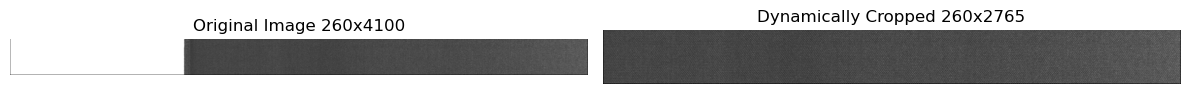

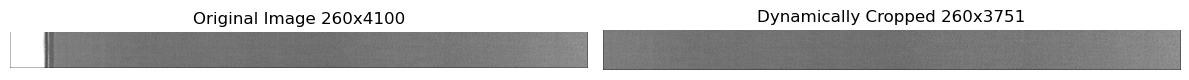

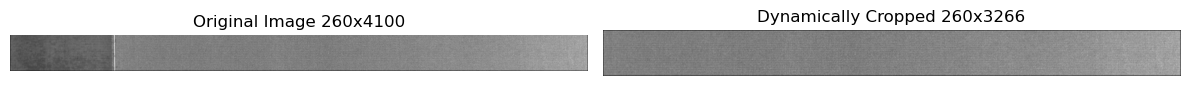

In [1]:
from codebase.data.cropping import crop_fabric_region, add_border
import os
import cv2
import matplotlib.pyplot as plt

def test_dynamic_crop(image_path: str):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not found or unable to read.")
        return

    cropped = crop_fabric_region(img)

    # Add black border to help visibility
    img_bordered = add_border(img, border_size=2, color=0)
    cropped_bordered = add_border(cropped, border_size=2, color=0)

    # Visualization
    _, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(img_bordered, cmap='gray', vmin=0, vmax=255)
    axs[0].set_title(f"Original Image {img_bordered.shape[0]}x{img_bordered.shape[1]}")
    axs[1].imshow(cropped_bordered, cmap='gray', vmin=0, vmax=255)
    axs[1].set_title(f"Dynamically Cropped {cropped_bordered.shape[0]}x{cropped_bordered.shape[1]}")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Example usage (adjust path if needed)
example_path = "./data/NODefect_images/2311694-2040n7u/0005_000_00.png"

if os.path.exists(example_path):
    test_dynamic_crop(example_path)
else:
    print(f"Test image not found at: {example_path}")

example_path = "./data/NODefect_images/2306894-210033u/0003_000_02.png"

if os.path.exists(example_path):
    test_dynamic_crop(example_path)
else:
    print(f"Test image not found at: {example_path}")

example_path = "./data/NODefect_images/2311980-185026u/0001_000_06.png"

if os.path.exists(example_path):
    test_dynamic_crop(example_path)
else:
    print(f"Test image not found at: {example_path}")

<div style="border-left: 4px solid #28a745; padding: 0.8em; background-color: #eafaf1; margin-bottom: 1em;">
  <strong>💡 Hint:</strong> <br><br> I added a border visually to better display the images on white backgrounds. So the vertical size of 256 increased slightly to 260. But this is only for the visualization here.
</div>

---

## 3. Image Tiling: Splitting into Patches
The raw images are very wide (4096 pixels), which makes them impractical for direct training. To address this, we divide each cropped image into smaller tiles or patches.

Recommended patching strategy:
- Tile size: 256×256 (based on model capacity and memory constraints)
- Use non-defective patches from clean images for training
- Use tiles from defect images for evaluation (with or without masks)

This approach significantly increases the training dataset size while ensuring uniform input dimensions for the model.

In [21]:
from codebase.data.patching import NODefectPatchCreator

creator = NODefectPatchCreator(
    input_folder="./data/NODefect_images",
    output_folder="./artifacts/preprocessed_patches/256x256/NODefect",
    patch_size=(256, 256),
    prefix="normal",
    exclude_fabric_codes=["00005"] # Exclude specific fabric codes because they aren't in training set
)

creator.process_and_save_patches()

[Skipped] Excluding fabric code: 00005 (0009_000_05.png)
[Skipped] Excluding fabric code: 00005 (0005_000_05.png)
[Skipped] Excluding fabric code: 00005 (0019_000_05.png)
[Skipped] Excluding fabric code: 00005 (0012_000_05.png)
[Skipped] Excluding fabric code: 00005 (0018_000_05.png)
[Skipped] Excluding fabric code: 00005 (0001_000_05.png)
[Skipped] Excluding fabric code: 00005 (0010_000_05.png)
[Skipped] Excluding fabric code: 00005 (0002_000_05.png)
[Skipped] Excluding fabric code: 00005 (0013_000_05.png)
[Skipped] Excluding fabric code: 00005 (0008_000_05.png)
[Skipped] Excluding fabric code: 00005 (0015_000_05.png)
[Skipped] Excluding fabric code: 00005 (0011_000_05.png)
[Skipped] Excluding fabric code: 00005 (0016_000_05.png)
[Skipped] Excluding fabric code: 00005 (0007_000_05.png)
[Skipped] Excluding fabric code: 00005 (0003_000_05.png)
[Skipped] Excluding fabric code: 00005 (0017_000_05.png)
[Skipped] Excluding fabric code: 00005 (0006_000_05.png)
[Skipped] Excluding fabric code

The next part is the preparation of the defect images and their masks. Here we also crop and create patches for each defect image and their mask counterpart.

In [22]:
from codebase.data.mask_alignment import DefectPatchCreator

creator = DefectPatchCreator(
    defect_folder="./data/Defect_images",
    mask_folder="./data/Mask_images",
    image_output_folder="./artifacts/preprocessed_patches/256x256/Defect",
    mask_output_folder="./artifacts/preprocessed_patches/256x256/Mask",
    patch_size=(256, 256),
    prefix="defect",
    fabric_codes_intact_image_path="./artifacts/preprocessed_patches/256x256/Intact",
    intact_fabric_codes=["00000"] # we can add this to the training data
)
creator.process_and_save_patches()

[!] No corresponding mask found for: ./data/Defect_images/0044_019_04.png
[!] No corresponding mask found for: ./data/Defect_images/0100_025_08.png
[!] No corresponding mask found for: ./data/Defect_images/0097_030_03.png
Saved 1353 patches (defect and intact) to:
  Defect Images: ./artifacts/preprocessed_patches/256x256/Defect
  Defect Masks:  ./artifacts/preprocessed_patches/256x256/Mask
  Intact Images for fabrics ['00000']: ./artifacts/preprocessed_patches/256x256/Intact


---

## 4. Dataset Handling and Preprocessing Steps
After cropping and tiling, each image patch undergoes the following preprocessing:
- Convert to grayscale tensors (if using PyTorch: shape `[1, H, W]`)
- Normalize pixel values to `[0, 1]` or `[-1, 1]`
- Optionally apply small augmentations (e.g., random flips, rotations) to improve generalization
- Organize into:
  - Training set: Only normal tiles
  - Testing set: Defective tiles + some normal tiles for reference

To streamline training, we will define a PyTorch-style `Dataset` class that:
- Loads preprocessed image tiles
- Returns tensors ready for model input
- Filters images by fabric code


In [24]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from codebase.data.dataset import FabricPatchDataset
from torch.utils.data import DataLoader

batch_size = 128

# Test the train dataset
train_dataset = FabricPatchDataset(
    image_dir="./artifacts/preprocessed_patches/256x256/NODefect", #/2311517-195063u",
    mode="train",
    normalize="zero-one",
    augment=True,
    image_size=256,
    #fabric_code="00004" # 210 images with that code
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test the test dataset
test_dataset = FabricPatchDataset(
    image_dir="./artifacts/preprocessed_patches/256x256/Defect",
    mask_dir="./artifacts/preprocessed_patches/256x256/Mask",
    mode="test",
    normalize="zero-one",
    image_size=256,
    #fabric_code="00004" # there are 73 defect images with that code
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for i, (x, y_mask, y_label, _, _) in enumerate(test_loader):
    print("Image batch shape:", x.shape)
    print("Mask batch shape:", y_mask.shape)
    print("Patch-level labels:", y_label)
    break  # just one batch for demonstration

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using FFT transform: False
Using histogram equalization: False
Using image size: 256
Using channel repeating: False
Using normalization: zero-one
Using augmentations: True
Using FFT transform: False
Using histogram equalization: False
Using image size: 256
Using channel repeating: False
Using normalization: zero-one
Using augmentations: False
Image batch shape: torch.Size([128, 1, 256, 256])
Mask batch shape: torch.Size([128, 1, 256, 256])
Patch-level labels: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


<details>
<summary><strong>Advanced: z-norm or zero-one norm?</strong></summary>

There’s a meaningful distinction between **0–1 normalization** and **z-normalization (zero-mean, unit-variance)** when it comes to image data in deep learning, particularly for anomaly detection.

---

### 🔍 Quick Definitions

| Normalization | Formula | Resulting Range | Typical Use |
|---------------|---------|-----------------|-------------|
| **0–1 scaling** | `x / 255` | `[0, 1]` | Common for raw images |
| **z-norm**     | `(x - μ) / σ` | Mean 0, Std 1 | Common for pretrained models or standardization needs |

---

### 🧠 Does z-norm make sense for image intensity?

#### ✅ It can. **If done correctly**, and under the right conditions.

But it's **not always necessary or better** than 0–1 scaling.

Let’s compare:

---

### ⚖️ Comparison: 0–1 Normalization vs. z-Norm

#### 🔹 0–1 Normalization (`ToTensor()`)

- **Simple, intuitive**
- Keeps pixel values in a **bounded range** `[0, 1]`
- Most useful when:
  - You're training from scratch
  - The model doesn't rely on specific input distribution
  - You're using MSE-based loss (e.g., autoencoder reconstruction)

✅ **Best for anomaly detection autoencoders** trained on raw grayscale images.

---

#### 🔸 z-Normalization (`(x - μ) / σ`)

- Normalizes brightness/contrast differences
- Can **center the data** better for some optimizers (especially when images vary in contrast)
- Often used with pretrained models (e.g., ResNet, VGG) which expect `mean/std` normalized RGB

But:  
- For grayscale anomaly detection, z-norm may **not offer real benefits**
- Worse, it could **distort low-level texture details** critical for detecting anomalies

---

### 🧪 Recommendation for the AITEX Fabric Dataset

| Use Case                        | Recommended Normalization |
|--------------------------------|---------------------------|
| Grayscale Autoencoder from scratch | ✅ 0–1 normalization |
| Color pretrained network         | 🔄 z-norm (with dataset-specific μ, σ) |
| Consistent lighting, industrial setting | ✅ 0–1 is clean and reliable |
| Highly variable contrast/lighting | 🟡 z-norm could help (but test carefully) |

</details>

Original image stats:
  min: 76 max: 184 mean: 118.31906127929688
Transformed image stats:
  min: 90 max: 160 mean: 118.44219970703125


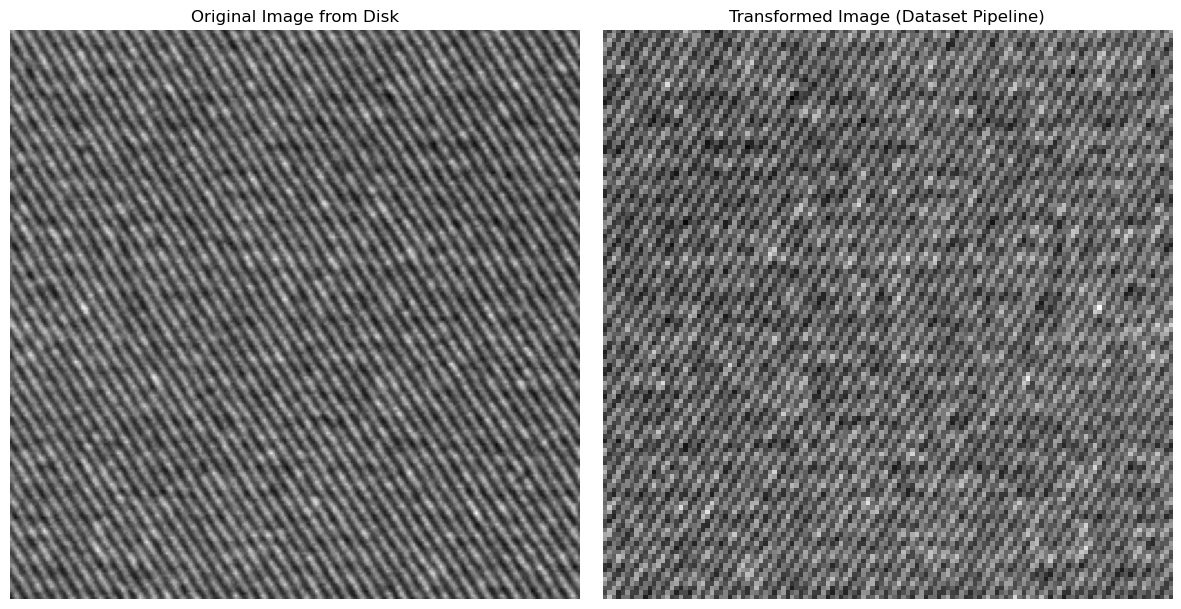

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch

# Path to your sample image
img_path = "./artifacts/preprocessed_patches/256x256/NODefect/2311517-195063u/normal_00004_00501.png"
image_size = 128
normalize = "zero-one"  # or "z-norm"
mode = "train"
augment = True

# ------------------------------
# Define transform pipeline (replicates your dataset)
tfms = []

if image_size:
    tfms.append(transforms.Resize((image_size, image_size)))

tfms.append(transforms.Grayscale(num_output_channels=1))
tfms.append(transforms.ToTensor())  # Converts to [0, 1]

if normalize == 'z-norm':
    tfms.append(transforms.Normalize(mean=[0.5], std=[0.5]))  # [-1, 1] range

# Optional augmentations (only in training mode)
if augment and mode == "train":
    aug = transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        # Add more if needed
    ], p=0.7)
    tfms = [aug] + tfms

transform_img = transforms.Compose(tfms)

# ------------------------------
# Load original image (PIL)
img_orig = Image.open(img_path).convert("L")
img_orig_np = np.array(img_orig)

# Apply full dataset transform
img_transformed = transform_img(img_orig)  # shape: (1, H, W)
img_transformed_np = img_transformed.squeeze().numpy()

# Convert for visual comparison (to 0–255 if needed)
if normalize == "z-norm":
    # Convert from [-1, 1] to [0, 255]
    img_vis = ((img_transformed_np + 1.0) / 2.0) * 255.0
else:
    # Convert from [0, 1] to [0, 255]
    img_vis = img_transformed_np * 255.0

img_vis = img_vis.astype(np.uint8)

# ------------------------------
# Print intensity statistics
print("Original image stats:")
print("  min:", img_orig_np.min(), "max:", img_orig_np.max(), "mean:", img_orig_np.mean())
print("Transformed image stats:")
print("  min:", img_vis.min(), "max:", img_vis.max(), "mean:", img_vis.mean())

# ------------------------------
# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_orig_np, cmap='gray')
axes[0].set_title("Original Image from Disk")
axes[0].axis("off")
axes[1].imshow(img_vis, cmap='gray')
axes[1].set_title("Transformed Image (Dataset Pipeline)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

---

## 5. Exploratory Visualization
To better understand the data, we will visualize several steps:
- A full original image and its cropped version
- A visual example showing how the image is tiled
- One or more individual patches for inspection

These visualizations help validate that our preprocessing pipeline is correctly isolating the fabric texture and preparing clean model inputs.

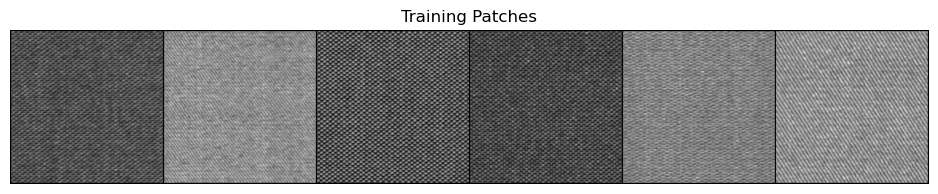

In [27]:
from codebase.data.visualization import show_train_batch

# For train mode
for images in train_loader:
    show_train_batch(images, n=6)
    break

And here are some images with their masks. The number in the image patch corresponds to the label (0 intact, 1 defect) in the mask patch.

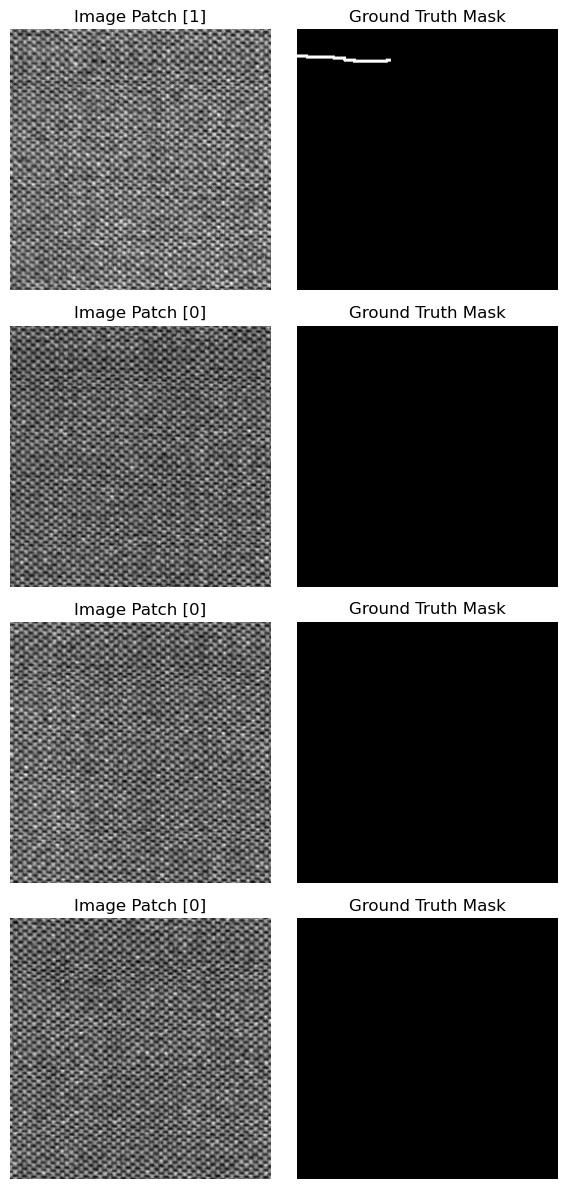

In [28]:
from codebase.data.visualization import show_test_batch

# For test mode
for images, masks, labels, _, _ in test_loader:
    show_test_batch(images, masks, labels, n=4)
    break

Let's now filter for **defect** patches only and **visualize** a few of them.

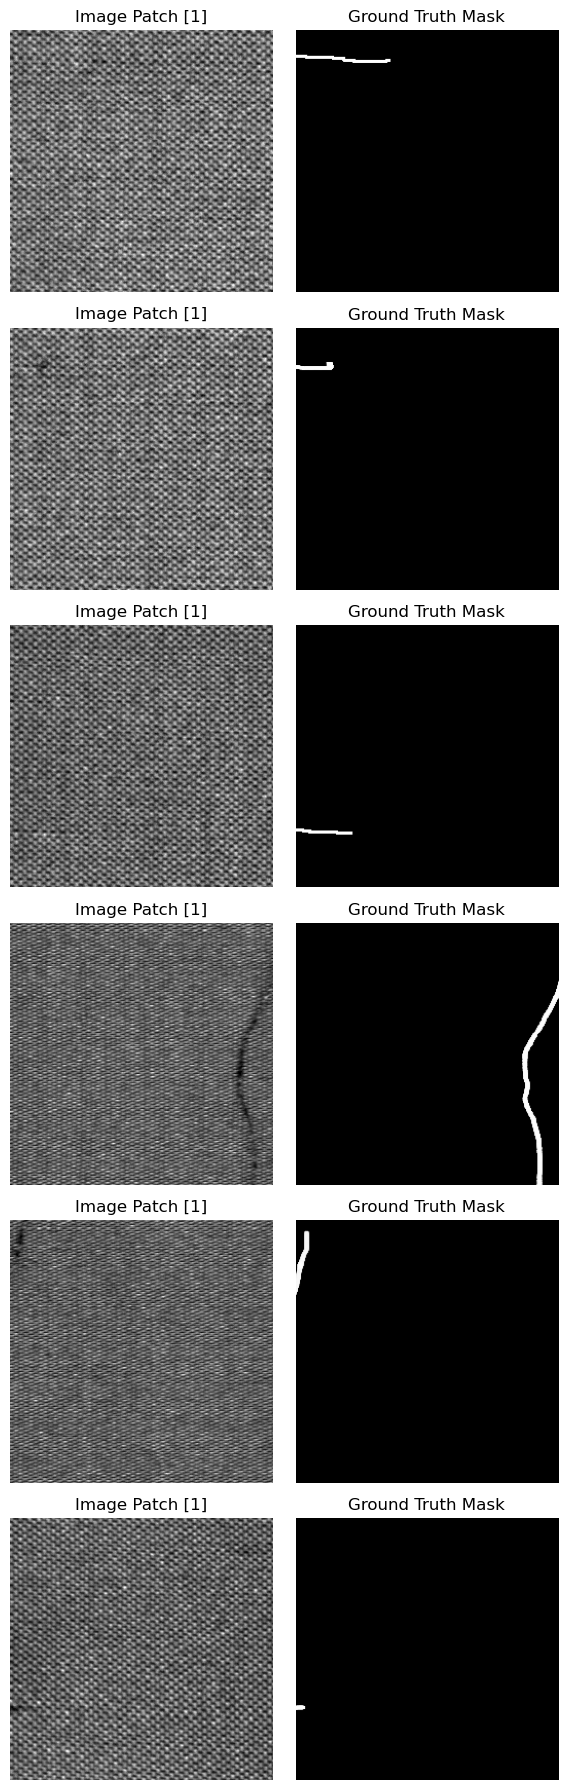

In [29]:
from codebase.data.visualization import show_test_batch
import torch

# Collect all defective samples
defect_images = []
defect_masks = []
defect_labels = []

for images, masks, labels, _, _ in test_loader:
    for img, mask, label in zip(images, masks, labels):
        if label == 1:
            defect_images.append(img)
            defect_masks.append(mask)
            defect_labels.append(label)

    # Stop after collecting enough defect samples
    if len(defect_images) >= 8:
        break

# Stack and show the first 6 defect patches
if len(defect_images) > 0:
    imgs_tensor = torch.stack(defect_images[:6])
    masks_tensor = torch.stack(defect_masks[:6])
    labels_tensor = torch.tensor(defect_labels[:6])
    show_test_batch(imgs_tensor, masks_tensor, labels_tensor, n=6)
else:
    print("No defect patches found in test set.")

---

## 6. 🔚 Conclusion & Outlook

In this notebook, we transformed raw AITEX fabric images into a structured, high-quality format ready for modeling. Key highlights included:

- Understanding the dataset structure (NODefect, Defect, Mask images),
- Dynamically cropping non-fabric margins,
- Visualizing intensity and structure in both normal and defective images,
- Preparing image patches for neural network consumption.

These steps ensure we work with consistent, meaningful data and set the stage for effective anomaly detection.

---

### Coming Up Next: Building the Variational Autoencoder (VAE)

With the dataset prepared, we now shift our focus to **building a custom Variational Autoencoder** tailored to the characteristics of our fabric data.

In the next notebook, we’ll:
- Build a CNN-based encoder and decoder architecture,
- Incorporate KL divergence for latent space regularization,
- Train the VAE on normal patches from the AITEX dataset,
- Visualize reconstructions and latent embeddings.

The goal? To learn a compressed latent representation of normal textures - so any deviation from that learned space can signal a potential defect.

<p style="font-size: 0.8em; text-align: center;">© 2025 Oliver Grau. Educational content for personal use only. See LICENSE.txt for full terms and conditions.</p>